<a href="https://colab.research.google.com/github/M-MSilva/Analyzing-User-Satisfaction-in-Applications---end_to_end_project/blob/main/jupyterNotebook/Analyzing_User_Satisfaction_in_ApplicationsNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing User Satisfaction in Applications - end_to_end 


The purpose of this project is to carry out a sentiment analysis, to understand the opinion of users in relation to google play applications and products. Therefore, we want to understand the users' point of view regarding google play applications, for this we will examine the criticisms and comments that these users have made on the platform. In addition, we will answer business questions:

1. Which days were the updates made that most influenced the number of installs?
2. Which apps have the most installs?
3. What categories, genres and maturity ratings of apps have been installed the most?
4. Which Categories, Genres, maturity ratings were rated the best by users?
5. What exactly were the highest scoring apps?

## 1 - Initial Requirements

Always at the beginning of a project we must import some elementary libraries.



In [ ]:
#for data processing
import pandas as pd
import numpy as np

#images
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_theme()

#to work with data and organize folders
import os
import urllib.request
import zipfile


#For prediction we use neural networks
import tensorflow as tf
from tensorflow  import keras

#to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## 2 - Download Data

First we define the environment in which we will leave our data, whose folder will be /Sentiment_Analysis/GoogleData/, in the next step we collect the zipped data from the link below, finally we send the data to this folder, and extract all of them to make the data sets of csv in dataframe. The original data link https://www.kaggle.com/datasets/lava18/google-play-store-apps and license is https://creativecommons.org/licenses/by/3.0/. It is worth noting that we changed the data a little, as can be seen in the Exploratory Data Analysis and Feature Engineering section.

In [ ]:
#we take the download url and select where we want our data to touch
DOWNLOAD = 'https://github.com/M-MSilva/Analyzing-User-Satisfaction-in-Applications---end_to_end_project/blob/main/DataForGoogleApps/GoogleAppsData.zip?raw=true'
DATA_PATH = os.path.join("Sentiment_Analysis", "GoogleData")
LocalData = "Sentiment_Analysis/GoogleData/GoogleAppsData.zip"
DATA_URL = DOWNLOAD + LocalData

#We extract all the zipped data and put it in the /Sentiment_Analysis/GoogleData/ folder
def getting_data_from_google(data_url=DATA_URL, data_path=DATA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    zip_path = os.path.join(data_path, "GoogleAppsData.zip")
    urllib.request.urlretrieve(data_url,zip_path)
    archive = zipfile.ZipFile(zip_path, 'r')
    archive.extractall(path=data_path)
    archive.close()

#we call the function
getting_data_from_google()

#we take the csv files and turn them into dataframes
csv_path_googleplaystore = os.path.join(DATA_PATH, "googleplaystore.csv")
csv_path_userApps = os.path.join(DATA_PATH, "googleplaystore_user_reviews.csv")

googleplaystore = pd.read_csv(csv_path_googleplaystore,encoding='utf-8',decimal='.', thousands=',')
googleplaystore_user_reviews = pd.read_csv(csv_path_userApps,encoding='utf-8', thousands=',')

Here we have two datasets, we will probably use googleplaystore more for getting insights, visualizing data and answering business questions, already the googleplaystore_user_reviews dataset will be employed in the model.

## 3 - Initial Data Insights

As seen above we have two datasets, so at every step we will try to extract information from both datasets. After all the initial setup, we are ready to go to work and extract some precious information from our data. First, we use the `.head()` method on the dataframe to better understand the dataset.

In [ ]:
googleplaystore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Each row of this dataframe gives us information about an application, which contains various resources about them.

In [ ]:
googleplaystore_user_reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


This dataframe has 100 evaluations for each application, that is, each row is a different evaluation, but some applications can be repeated, despite having a different evaluation for each one.

### 3.1 - Glossary of user reviews

Now let's better understand the data from the 'googleplaystore_user_reviews' file, since it has some different features, I won't do the same for the other file, because that data is self-explanatory.

*   App: Nome do Aplicativo;
*   Translated_Review: User review (Pre-processed and translated into English);
* Sentiment: Data that tells us whether or not the user liked the app, i.e. positive, neutral, or negative feeling (categorical);
* Sentiment_Polarity: Similar to the previous one, this data tells us the positivity or negativity of an affirmation, the difference is that here we have values that go from [-1,1], so we have positive and negative feelings of affirmations in the form of numbers;
* Sentiment_Subjectivity: It tells us how much a user appreciates the app and exposes (or declares) their point of view about it. The domain of this variable varies between [0.1], 0.0 is very objective and 1.0 is very subjective.



### 3.2 - Dataset Summary

After understanding some attributes, we can get a description of the data with the `.info()` method.

In [ ]:
googleplaystore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


We noticed that this dataset has 10841 rows, as we also noticed that some data is in wrong types, which is the case of size and Installs. We can also check if there is polluted data in the other dataset:

In [ ]:
googleplaystore_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


It appears that this last dataset will not need initial cleaning, only further processing.

### 3.3 - Pre Processing

As our data is polluted we clean it up a bit using the `.replace()` :

In [ ]:
googleplaystore.replace({'Installs':{'\+': '',',':'','Free':''},'Android Ver':{'and up': '','and up': ''},
                         'Price':{'\$': '','$':'','Everyone': np.nan},'Size':{"Varies with device":'',"\+":'',"1,000":'1'},
                         'Android Ver':{"Varies with device":'Varies/device'},'Rating':{19:1.9}},inplace=True,regex=True)
                      



we make the application size always in the megabit unit of measurement, and we transform the Size column into numeric,

In [ ]:
def ToMegabyte(data):
    if type(data) == float or type(data) == int:
      return data
    if 'k' in data:
        if len(data) > 1:
          return (float(data.replace('k', ''))*0.001)
    if 'B' in data:
      return float(data.replace('B', '')) * 1e-6
    if 'G' in data:
      return float(data.replace('G', ''))*1000
    if 'M' in data:
      return float(data.replace('M', ''))
    else:
      return data

googleplaystore['Size'] = pd.to_numeric(googleplaystore['Size'].apply(ToMegabyte))

we perform a similar operation here,

In [ ]:
def tomillion(data):
    if type(data) == float or type(data) == int:
      return data
    elif 'M' in data:
        if len(data) > 1:
          return (float(data.replace('M', '')))*1e6
    else:
      return data

googleplaystore['Reviews'] = pd.to_numeric(googleplaystore['Reviews'].apply(tomillion))


and we transform the strings into dates.

In [ ]:
from datetime import datetime

def to_date(d):
  try:
    return datetime.strptime(d, '%B %d, %Y').strftime('%Y-%m-%d')
  except ValueError:
    return pd.NaT

googleplaystore['Last Updated'] = googleplaystore['Last Updated'].apply(to_date).astype('datetime64[D]')

Finally, we changed the price and Installs to be numbers and removed all duplicate apps:

In [ ]:
googleplaystore['Price'] = pd.to_numeric(googleplaystore['Price'])
googleplaystore['Installs'] = pd.to_numeric(googleplaystore['Installs'])
googleplaystore.shape

(10841, 13)

In [ ]:
googleplaystore.drop_duplicates(subset='App', inplace=True, ignore_index=True)
googleplaystore.shape

(9660, 13)

We also have apps that are repeated in the other dataset, however, as we have different criticisms there regarding the same app, so we should keep the dataset like this.

### 3.4 - Understanding the data

#### 3.4.1 - Numerical Data

Now that we know what our numeric attributes are, we can plot them in the form of a histogram. Let's plot various app information on the x-axis by the frequency density on the y-axis using the googleplaystore dataframe.

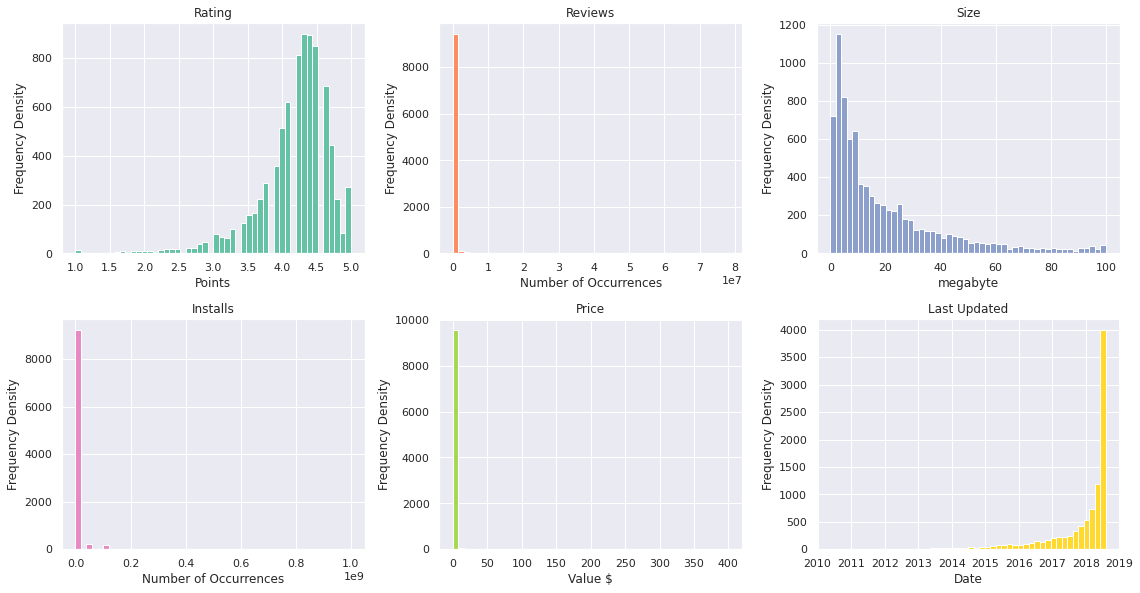

In [ ]:
cmap = mpl.cm.Set2

gAppCopy = googleplaystore.copy()
gReviewCopy = googleplaystore_user_reviews.copy()

fig=plt.figure(figsize=(16,12))

#list with the x label
measurement = ['Points','Number of Occurrences',
               'megabyte','Number of Occurrences','Value $','Date']

gOne_num = list(googleplaystore.select_dtypes(include=[np.number]))
gOne_num.append("Last Updated")

#loop that plots all the charts we want, using the hist() method
for i, x, in zip(enumerate(gOne_num),measurement):
  ax=fig.add_subplot(3,3,i[0]+1)
  gAppCopy[i[1]].hist(bins=50,ax=ax,color=cmap(i[0]))
  ax.set_xlabel(x)
  ax.set_ylabel('Frequency Density')
  ax.set_title(i[1])
fig.tight_layout()
plt.show()

It is worth noting that some data have high values of more and low values of more, as the greatest concentration of data is usually in smaller values, it seems that we only have a few smaller data, but we have high values as well.

In [ ]:
print("max price: %s $, and the max Reviews: %s reviews" % (max(gAppCopy['Price']), max(gAppCopy['Reviews'])))

max price: 400.0 $, and the max Reviews: 78158306.0 reviews


Furthermore, in the chart above we see that the majority of the rating is at 4.5 points, and most of the google play apps are free, another interesting thing in our dataset seems to be the size of the app, which is much more distributed than the others. data, as well as showing us that most applications appear to be 2mb. Finally, we see that the apps were more updated in 2019 than in other years.

We do the same with the User Review dataframe:

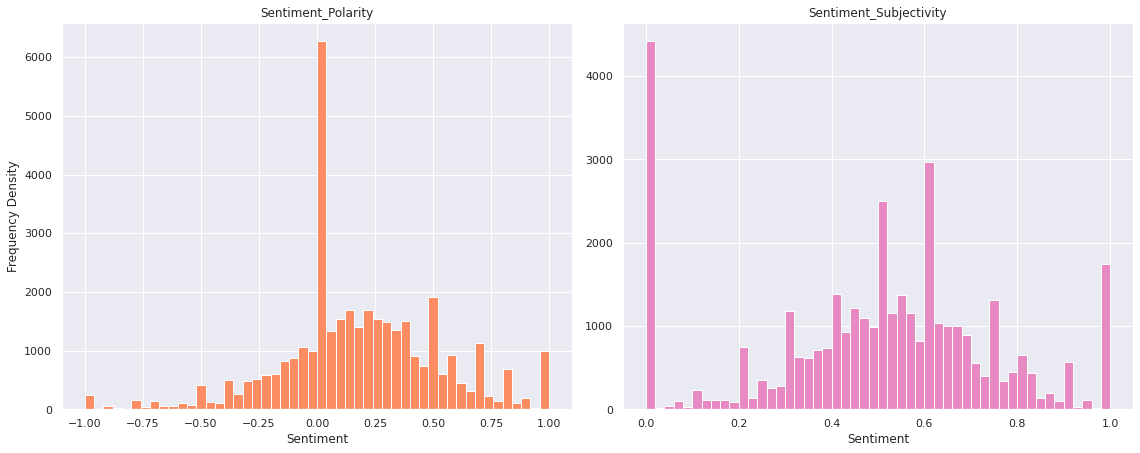

In [ ]:
cmap = mpl.cm.Set2

fig=plt.figure(figsize=(16,12))

#we plot Sentiment Polarity
ax=fig.add_subplot(2,2,1)
gReviewCopy['Sentiment_Polarity'].hist(bins=50,ax=ax,color=cmap(1))
ax.set_ylabel('Frequency Density')
ax.set_title('Sentiment_Polarity')
ax.set_xlabel('Sentiment')
fig.tight_layout()


#we plot Sentiment Subjectivity
ax=fig.add_subplot(2,2,2)
gReviewCopy['Sentiment_Subjectivity'].hist(bins=50,ax=ax,color=cmap(3))
ax.set_xlabel('Sentiment')
ax.set_title('Sentiment_Subjectivity')
fig.tight_layout()

plt.show()

And we noticed that most of the statements are neutral, in the Sentiment Subjectivity variable we noticed that most of the reported sentences are objective.

To understand the data in an easier way, we will use the `.describe()` method:

In [ ]:
gAppCopy.describe()

,Rating,Reviews,Size,Installs,Price
count,8197.000000,9.660000e+03,8433.000000,9.659000e+03,9659.000000
mean,4.172966,2.168807e+05,20.392989,7.777507e+06,1.099299
std,0.537179,1.831444e+06,21.827270,5.375828e+07,16.852152
min,1.000000,0.000000e+00,0.008500,0.000000e+00,0.000000
25%,4.000000,2.500000e+01,4.600000,1.000000e+03,0.000000
50%,4.300000,9.670000e+02,12.000000,1.000000e+05,0.000000
75%,4.500000,2.942025e+04,28.000000,1.000000e+06,0.000000
max,5.000000,7.815831e+07,100.000000,1.000000e+09,400.000000


We capture the low standard deviation of the Rating indicating the greater proximity of the data in relation to the average, Reviews and Installs have a high standard deviation indicating the greater dispersion of data in relation to the average, in addition to other self-explanatory information.

In [ ]:
gReviewCopy.describe()

,Sentiment_Polarity,Sentiment_Subjectivity
count,37432.000000,37432.000000
mean,0.182146,0.492704
std,0.351301,0.259949
min,-1.000000,0.000000
25%,0.000000,0.357143
50%,0.150000,0.514286
75%,0.400000,0.650000
max,1.000000,1.000000


Here we see the low standard deviation in both features, as well as a very low mean since the domain of Sentiment_Polarity, Sentiment_Subjectivity are small.

#### 3.4.2 - Categorical Data

We had gotten more information about our numerical data, now it's time to understand the categorical data, as some categorical data is huge, so we should only plot the easiest to be visualized in the googleplaystore dataset, and for that we use the `.value_counts()` method.

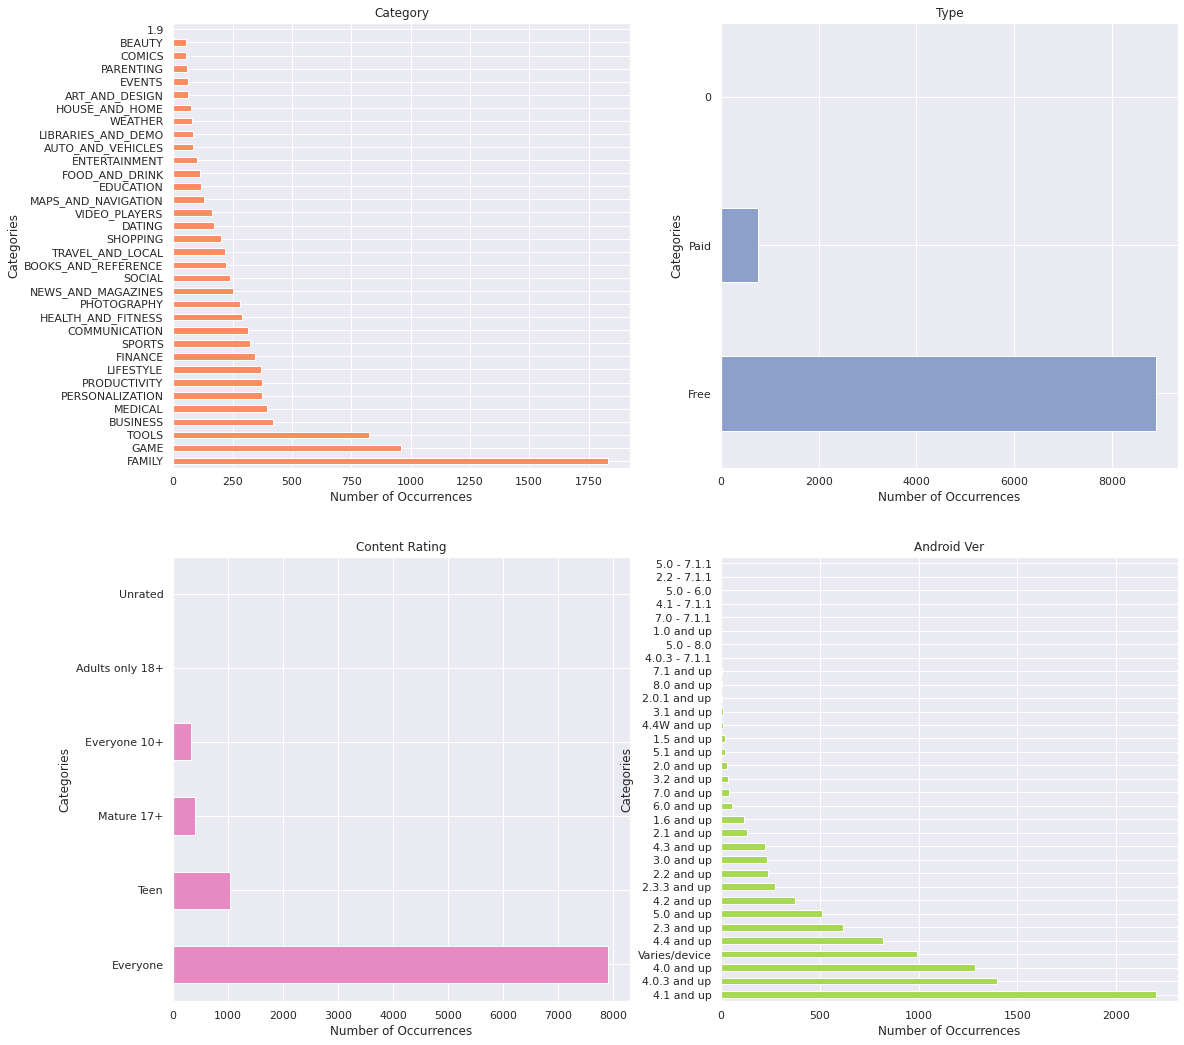

In [ ]:
gpObject = ['Category','Type','Content Rating','Android Ver']

fig=plt.figure(figsize=(18,18))

#loop that plots all the data we want using the value_counts() method
for i, col in enumerate(gpObject):
  ax=fig.add_subplot(2,2,i+1)
  plt.xlabel('Number of Occurrences')
  plt.ylabel('Categories')
  valuec = gAppCopy[col].value_counts().plot(kind='barh',title=col,color=cmap(i + 1),grid=True,ax=ax)
plt.show()

We observed that the highest occurrences for category, type, content rating and android version are respectively ~ (1750 for family, 8000 for free, 8000 for everyone, 2300 for 4.1). In addition, some data were not plotted here, as they have many categories such as the genre, but we can plot this information, selecting only the 10 largest occurrences of the category

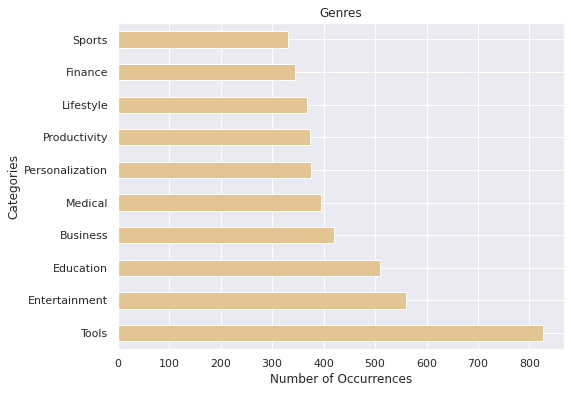

In [ ]:
n = 10
plt.xlabel('Number of Occurrences')
plt.ylabel('Categories')
gAppCopy['Genres'].value_counts()[:n].plot(kind='barh',title=col,color=cmap(6),grid=True,figsize=(8,6))
plt.title('Genres')
plt.show()

It is evident from the graph above that tools and entertainment are the most frequent genres in the dataset. In the other data set, only by the sentiment variable we can visualize something:

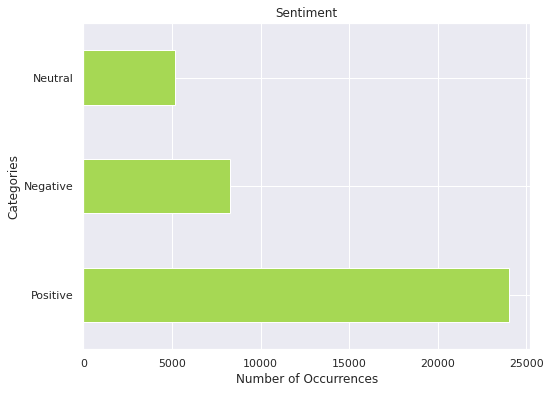

In [ ]:
plt.xlabel('Number of Occurrences')
plt.ylabel('Categories')
gReviewCopy['Sentiment'].value_counts().plot(kind='barh',title=col,color=cmap(4),grid=True,figsize=(8,6))
plt.title('Sentiment')
plt.show()

The positive class is the one that has more occurrences, as it also agrees with the rating data from the googleplaystore dataset, since by section 3.2 we find the mean and median of the raintg of ~ 4.2

## 5 - Visualizing data and Answering Some Business Questions

It's time for one of the coolest parts of the project, as after getting insights from our data we must answer the business questions, before moving on to the machine learning model.

#### 5.1 -  Best day to perform an app update

The first question we are going to answer is: which days were the updates made, which most influenced the number of installs? To answer this question, we will group the data into days of the month and add the data that happen on the same day, that is, we will aggregate values for each column in the dataset by day, as can be seen in the result below.

In [ ]:
fordate = googleplaystore.copy()

fordate.replace([np.inf, -np.inf], np.nan, inplace=True)

fordate.dropna(subset=["Last Updated"], how="all", inplace=True)

fordate['Day'] = fordate['Last Updated'].dt.day.astype(int)

results = fordate.groupby('Day').sum()

results.head()

,Rating,Reviews,Size,Installs,Price
Day,,,,,
1,1576.8,173630102.0,8580.874,6.870185e+09,1313.00
2,1628.8,166003367.0,9200.522,6.071260e+09,122.64
3,2016.7,371269755.0,9579.229,1.061718e+10,546.43
4,1108.9,91929649.0,5307.997,2.295793e+09,126.26
5,1255.3,68946815.0,5432.574,2.260111e+09,193.42


We plot the result:

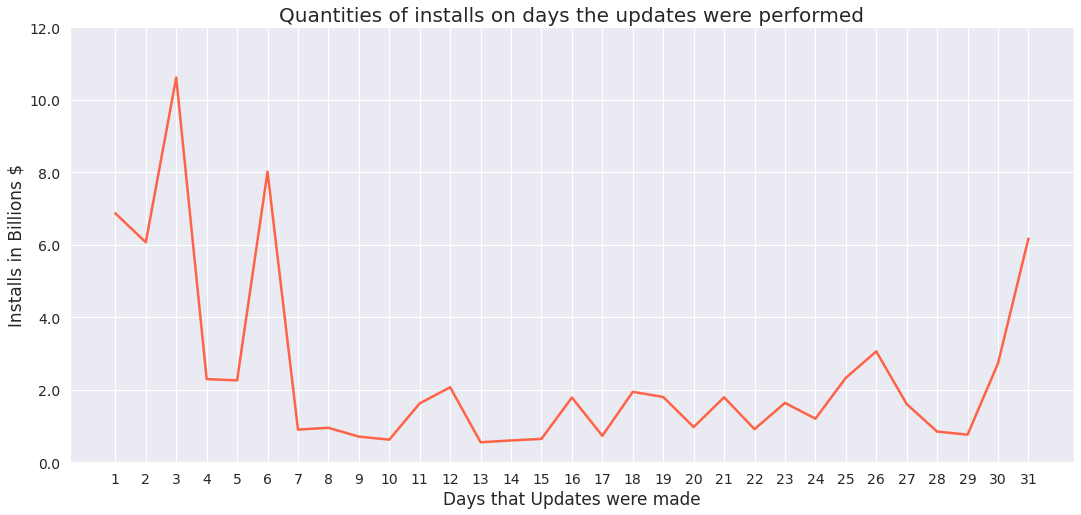

In [ ]:
day = range(1,32)


fig, ax= plt.subplots(figsize=(18, 8))
plt.plot(day,results['Installs'],lw=2.5,color='tomato')
labels,location = plt.yticks()
plt.yticks(labels,(labels/1e9))
plt.xticks(day)
plt.ylabel('Installs in Billions $',fontsize=17)
plt.xlabel('Days that Updates were made',fontsize=17)
plt.title('Quantities of installs on days the updates were performed',fontsize=20)

# change the fontsize
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=14)
               
plt.show()

Here we notice that the day with the most installations was on the 3rd, this means that the best day to perform an update is on the 3rd, as there will be more downloads.

#### 5.2 - Most installed apps on Devices

What if we want to know exactly which apps have the most installs? For this purpose we will take the 9 applications with the most installations using the `.nlargest()` method.

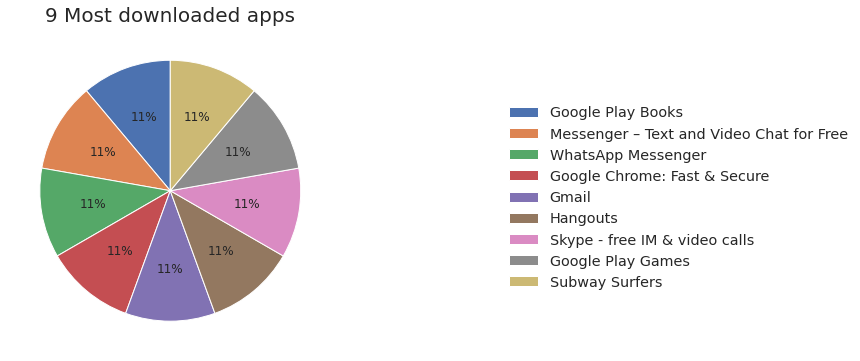

In [ ]:
anotherCopy = googleplaystore.copy()

anotherCopy = anotherCopy[anotherCopy['Installs'].notna()]

anotherCopy = anotherCopy.nlargest(9, columns=['Installs'])


fig = plt.figure(figsize =(10, 6))
plt.pie(anotherCopy['Installs'],
        shadow=False, startangle=90,autopct='%1.0f%%')
plt.title('9 Most downloaded apps',fontsize = 20)
plt.legend(frameon=False, bbox_to_anchor=(1.5,0.8),labels=anotherCopy['App'],fontsize='large')
plt.show()


Either our dataset is bad and doesn't have significant information about apps, or all this data has the same download numbers. Since we haven't found good information on individual apps, let's group some of the apps into classes.

#### 5.3 - Most installed App Classes 

Now we want to know which categories, Genres and maturity ratings of apps have been installed the most. To answer this question let's use the `.groupby('variable').sum()` method to group data of the same class and add that data.

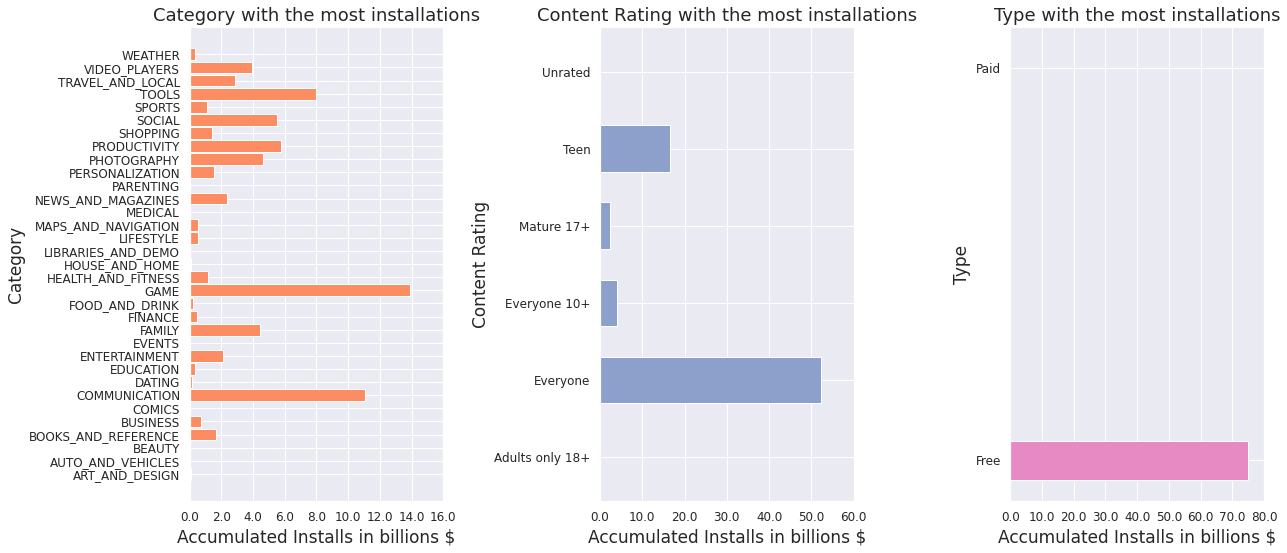

In [ ]:
#color map we use 
cmap3 = mpl.cm.Set2

#WE TAKE ONLY THE DATA ABOVE THE AVERAGE
justForvisu = gAppCopy[gAppCopy['Installs']>10000].copy()

labels1 = [cat for cat, justForvisu in justForvisu.groupby('Category')] 
labels3 = [typee for typee, justForvisu in justForvisu.groupby('Type')]
labels2= [cr for cr, justForvisu in justForvisu.groupby('Content Rating')]

#dictionary containing the labels to plot
apps_dict = {'l1':labels1,'l2':labels2,'l3':labels3}

#the list that we are going to go through to find the best ponctuate for each category
resultsList = ['Category','Content Rating','Type']

fig=plt.figure(figsize=(18,22))

height=[0.9,0.6,0.1]

for val,i,j in zip(enumerate(apps_dict.values()),resultsList,height):
  #use the groupby('Category').sum() methods to group the tracks for example and sum the data of their group
  results = justForvisu.groupby(i).sum()
  ax=fig.add_subplot(3,3,val[0]+1)
  #we plot the vertical bar
  ax.barh(val[1],results['Installs'],color=cmap3(val[0] + 1),height=j)
  labels,location = plt.xticks()
  plt.xticks(labels,(labels/1e9))
  ax.set_ylabel(i,fontsize=17)
  ax.set_xlabel('Accumulated Installs in billions $',fontsize=17)
  ax.set_title(i + ' with the most installations',fontsize=18)
  ax.tick_params(axis='both', which='minor', labelsize=12)
  ax.tick_params(axis='both', which='major', labelsize=12)  
fig.tight_layout()
plt.show()

Here we see that the category of applications that most installed were games and communication apps, as well as the most installed applications were those free for any public and for free.

#### 5.4 - Top rated app classes

The next question that we will answer is: which Categories, Genres, maturity ratings were the best rated by users? To answer this question let's use the `.groupby('variable').sum()` method to group data of the same class and add that data.

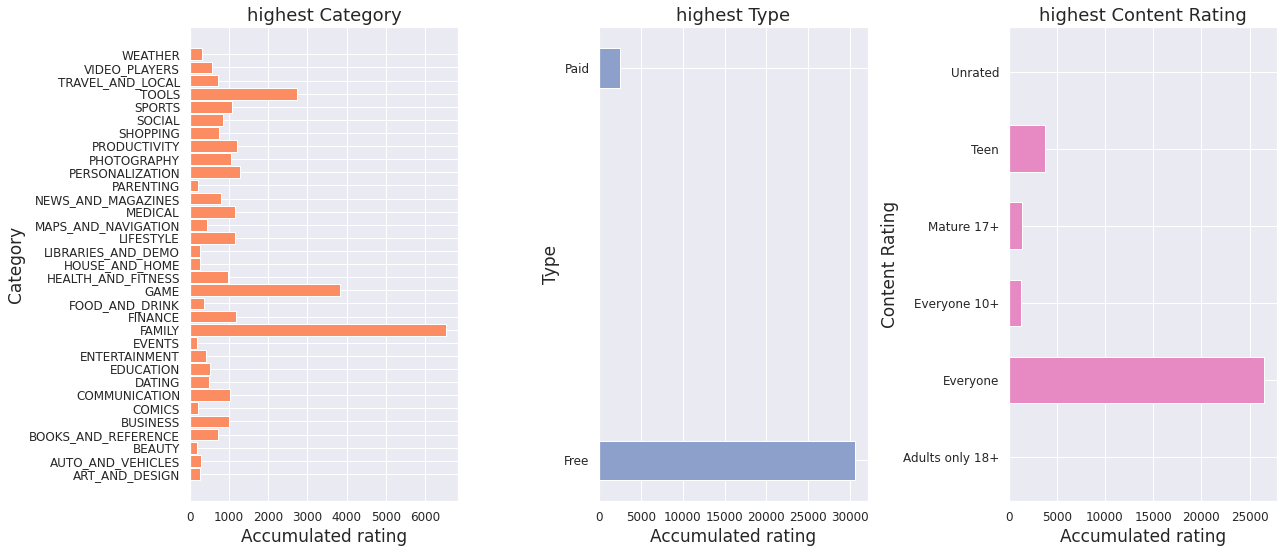

In [ ]:
#color map we use 
cmap3 = mpl.cm.Set2

#WE TAKE ONLY THE DATA ABOVE THE AVERAGE
justForvisuTwo = gAppCopy[gAppCopy['Rating']>3.1].copy()

labels1 = [cat for cat, justForvisuTwo in justForvisuTwo.groupby('Category')] 
labels2 = [typee for typee, justForvisuTwo in justForvisuTwo.groupby('Type')]
labels3= [cr for cr, justForvisuTwo in justForvisuTwo.groupby('Content Rating')]

#dictionary containing the labels to plot
apps_dict = {'l1':labels1,'l2':labels2,'l3':labels3}

#the list that we are going to go through to find the best ponctuate for each category
resultsList = ['Category','Type','Content Rating']

fig=plt.figure(figsize=(18,22))

height=[0.9,0.1,0.6]

for val,i,j in zip(enumerate(apps_dict.values()),resultsList,height):
  #use the groupby('Category').sum() methods to group the tracks for example and sum the data of their group
  results = justForvisuTwo.groupby(i).sum()
  ax=fig.add_subplot(3,3,val[0]+1)
  #we plot the vertical bar
  ax.barh(val[1],results['Rating'],color=cmap3(val[0] + 1),height=j)
  ax.set_ylabel(i,fontsize=17)
  ax.set_xlabel('Accumulated rating',fontsize=17)
  ax.set_title('highest ' + i,fontsize=18)
  ax.tick_params(axis='both', which='minor', labelsize=12)
  ax.tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
plt.show()

We can see in these charts that the apps with the highest ratings are the familiar, free apps that anyone of any age can play.

#### 5.5 - Most Rated Apps



To answer the question 'What exactly were the highest scoring apps?' we must first take, in addition to the best ratings, the highest numbers of reviwes, because it is useless to have a high rating if only one person evaluated it, for example.

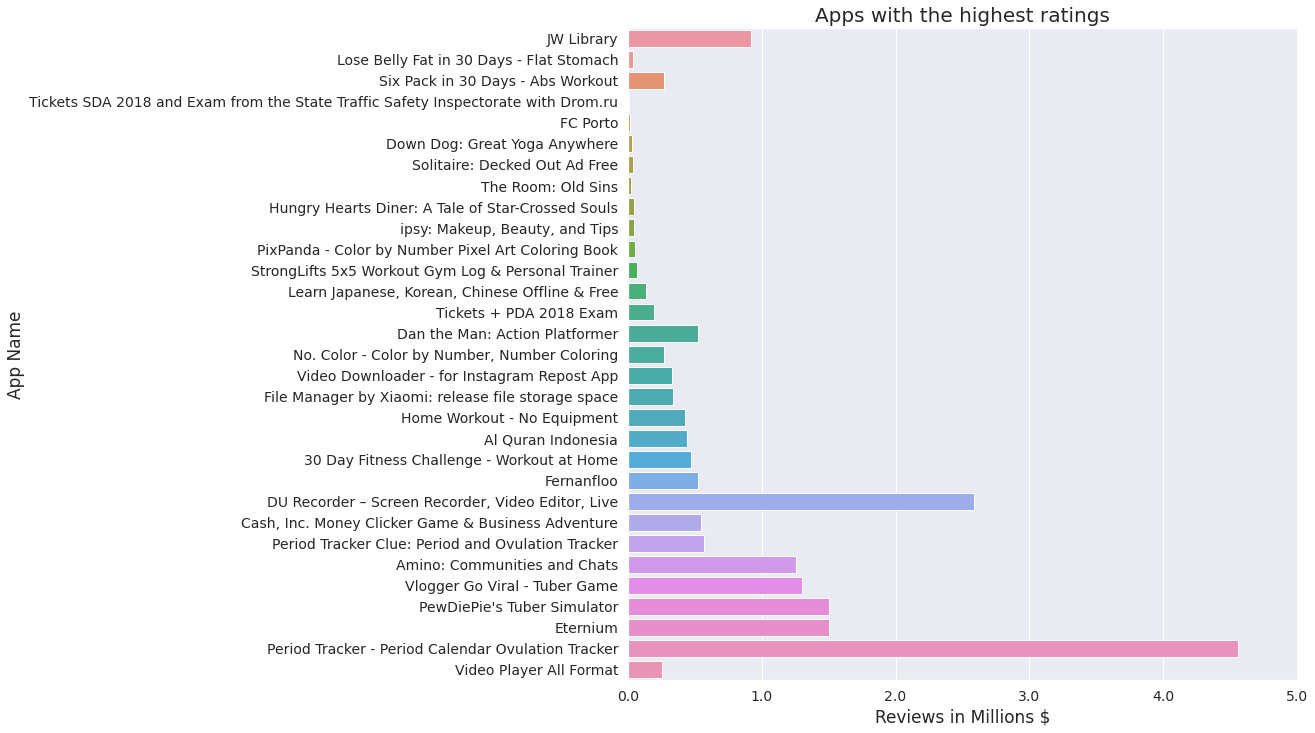

In [ ]:
#we plot

#take the highest Ratings and Reviews.
aux = gAppCopy[(gAppCopy['Rating']>4.3) & (gAppCopy['Reviews']>10000)]


#we select only the biggest Reviews, Rating, Installs
justForvisu = aux.nlargest(31, columns=['Rating','Reviews','Installs'],keep='all').copy().sort_values('Rating',ascending=False)


fig, ax= plt.subplots(figsize=(12, 12))

#since all these apps have high rankings the way to compare them is by the number of reviews
sns.barplot(x = justForvisu['Reviews'], y =justForvisu['App'])

labels,location = plt.xticks()
plt.xticks(labels,(labels/1e6))

plt.ylabel('App Name',fontsize=17)
plt.xlabel('Reviews in Millions $',fontsize=17)
plt.title('Apps with the highest ratings',fontsize=20)

ax.tick_params(axis='both', which='minor', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)


plt.show()

ratings are in descending order, so jm library is the highest rated app.

## 6 -  Exploratory Data Analysis and Feature Engineering

In this part of the code we will do a lot to extract information from our data, but first we will take a copy of the googleplaystore_user_reviews dataset and see what is inside it:

In [ ]:
user_reviews_copy = googleplaystore_user_reviews.copy()

user_reviews_copy['Translated_Review'].unique()

array(['I like eat delicious food. That\'s I\'m cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"',
       'This help eating healthy exercise regular basis', nan, ...,
       'Dumb app, I wanted post property rent give option. Website work. Waste time space phone.',
       'I property business got link SMS happy performance still guys need raise bar guys Cheers',
       'Useless app, I searched flats kondapur, Hyderabad . None number reachable I know flats unavailable would keep posts active'],
      dtype=object)

### 6.1 - A little more pre-processing

In the text data we have NaN data, so we will delete this data using `.notna()`

In [ ]:
user_reviews_copy = user_reviews_copy[user_reviews_copy['Translated_Review'].notna()]

We also noticed that we have some characters that can harm both our analysis and our model, so we will apply a lot of treatment to our data.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import re
import sys

#we create a function to remove tags and everything that is not text,
def preprocess(data):
    data = re.sub(r"<(?!br).*?>", " ",data)
    data = re.sub(r"[^a-zA-Z]", " ",data)
    return data

# we apply the above function in the reviews,
user_reviews_copy['Translated_Review'] = user_reviews_copy['Translated_Review'].apply(preprocess)


#we remove from our data the stop words that are common in English like 'I', 'this', 'is', 'in'.
stopwords = STOPWORDS
stopwords.update(['game','it','app','t','s','m'])

#We make the text from uppercase to lowercase,
user_reviews_copy['Translated_Review']= user_reviews_copy['Translated_Review'].\
                                        apply(lambda x: x.lower())

#we actually remove irrelevant words,
user_reviews_copy['Review_without_stopwords'] = user_reviews_copy['Translated_Review'].\
                                                apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

#we took all the criticism in the dataset and merged it all into a single string.
text = ' '.join(t for t in user_reviews_copy['Review_without_stopwords'])

### 6.2 - WordCloud and the most frequent words in reviews

Now that we've cleaned up our data let's visualize the most frequent words using a word cloud, in this graph the word size represents its importance or frequency.

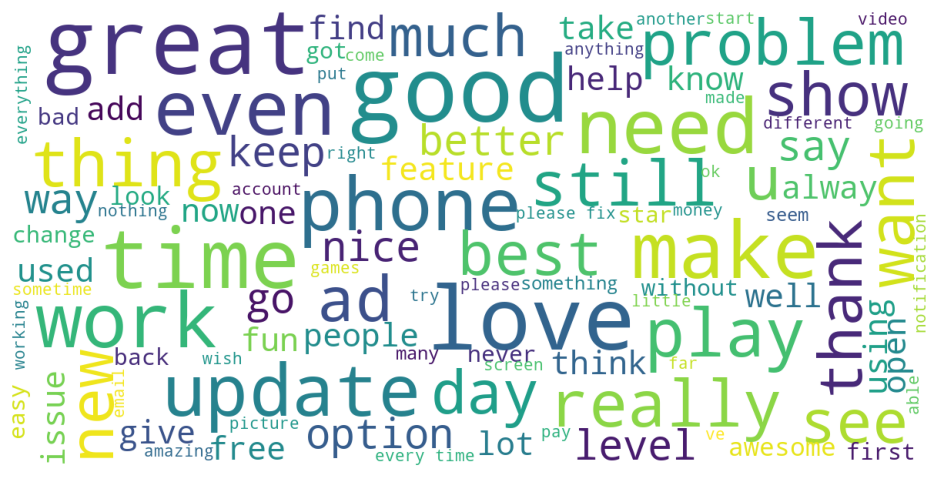

In [ ]:
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib

#We take the bottom of the seaborn,
matplotlib.rc_file_defaults()

#we choose the image size, as well as remove the plot axis
plt.figure(figsize=(12,6))
plt.axis("off")

# and we use imshow to illustrate the data as an image.
plt.imshow(
    WordCloud(background_color='white',max_words=100,
                      max_font_size=40,
                      scale=3,
                      random_state=6).generate(text)
)
plt.show()

Although the graph above is pretty it is difficult to understand as the words are messed up, so let's plot the most frequent words in each type of feeling 0 negative, 1 neutral, 2 positive. But the operation is not that simple, since in addition to grouping the criticisms for each feeling, we must also get each most common word in the criticisms, to have their respective class. At the end we plot graphs representing this operation.

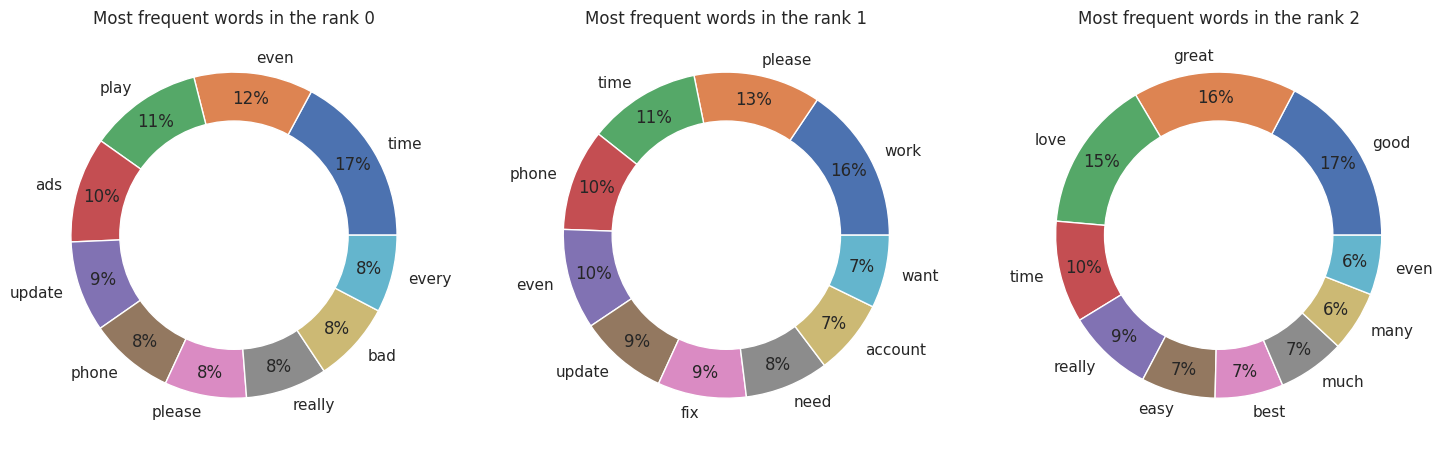

In [ ]:
from collections import Counter

#We group the words into classes,
group_by = user_reviews_copy.groupby('Sentiment')['Review_without_stopwords'].apply(lambda x: Counter(' '.join(x).split()).most_common(10))

#we will return with the seaborn theme,
sns.set_theme()

#and we select the image size.
fig=plt.figure(figsize=(18,18))

#We plot the three graphs by extracting group_by the frequency and group by words of each class:
for i in range(0,3):
  group_bycl = group_by.iloc[i]
  ax=fig.add_subplot(3,3,i+1)
  words,freq = map(list,zip(*group_bycl))

  ax.pie(x=freq,labels=words,autopct='%1.0f%%',pctdistance=0.85)
  ax.set_title('Most frequent words in the rank ' + str(i))

  my_circle=plt.Circle( (0,0), 0.7, color='white')
  p=plt.gcf()
  p.gca().add_artist(my_circle)
plt.show()


In this graph, we observe in the negative reviews that we have 'ads' as a frequent word, this means that the worst applications are those with a lot of advertisements, while in the neutral reviews we notice the prevalence of fix, which points out some problem or bug in the game. In addition, in this same class, we have the predominance of the word acoount, which indicates applications that probably force you to create an account for use. In the last class, the positive only has good things.

### 6.3 - Understanding Ngram in Data

Therefore, to better understand user criticism let's contemplate what we call ngram, whose meanings are sequences of words found in the text, for example a 2-gram = bigram can have the words 'wasted time' indicating a bad experience of a user in apps.


In [ ]:
# Initially we created three lists with positive, negative and neutral reviews,
positive = user_reviews_copy[user_reviews_copy['Sentiment']=='Positive']['Review_without_stopwords'].values.tolist()
neutral = user_reviews_copy[user_reviews_copy['Sentiment']=='Neutral']['Review_without_stopwords'].values.tolist()
negative = user_reviews_copy[user_reviews_copy['Sentiment']=='Negative']['Review_without_stopwords'].values.tolist()

em seguida usamos em conjunto a biblioteca `nlkt` para produzir nossa sequência de ngrams, e a CountVectorizer do sklearn para tokenizar (codificar os caracteres em inteiros) nossos dados. Posteriormente criamos uma matriz (bag_of_words), onde  cada coluna caracteriza uma palavra no vocabulário, e as linhas são um texto individual no corpus, dessa matriz somamos as ocorrencias das paralvas no texto com `.sum(axis= 0 )`. Finalmente pareamos as palavras e a sua ocorrencia em uma tupla e também ordenamos tais palavras de acordo com a maior frequência.


In [ ]:
from nltk.util import ngrams 
from sklearn.feature_extraction.text import CountVectorizer

#We create the function explained above,
def  topNgram(corpus, n=None) : 
    cVec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_words = cVec.transform(corpus)
    sum_words = bag_words.sum(axis= 0 )
    
    freq_of_words  = []
    for word, idx in cVec.vocabulary_.items():
      freq_of_words.append((word , sum_words[ 0 , idx]))
                   
    freq_of_words.sort(key=lambda tup: tup[1], reverse=True)
    return freq_of_words[:10]

#we call the above function and take the top 10 positive bigrams in the lists xp,yp,
xp,yp=map(list,zip(*topNgram(positive,2)[:10]))

#we repeat the above operation for the top 10 neutral bigrams.
xN,yN=map(list,zip(*topNgram(neutral,2)[:10]))

# We do the same for the negatives.
xM,yM=map(list,zip(*topNgram(negative,2)[:10]))

#We create dataframes with the above results of ngram,frequency,
# we don't put it in a single dataframe, because we want to plot information from each class,
#since using a single dataframe it would only be possible to plot a scatter with bad visualization.
dfpositive = pd.DataFrame(list(zip(xp,yp)), columns = ['ngram','frequency'])
dfNeutr = pd.DataFrame(list(zip(xN,yN)), columns = ['ngram','frequency'])
Negative = pd.DataFrame(list(zip(xM,yM)), columns = ['ngram','frequency'])

Plot of the information generated above:

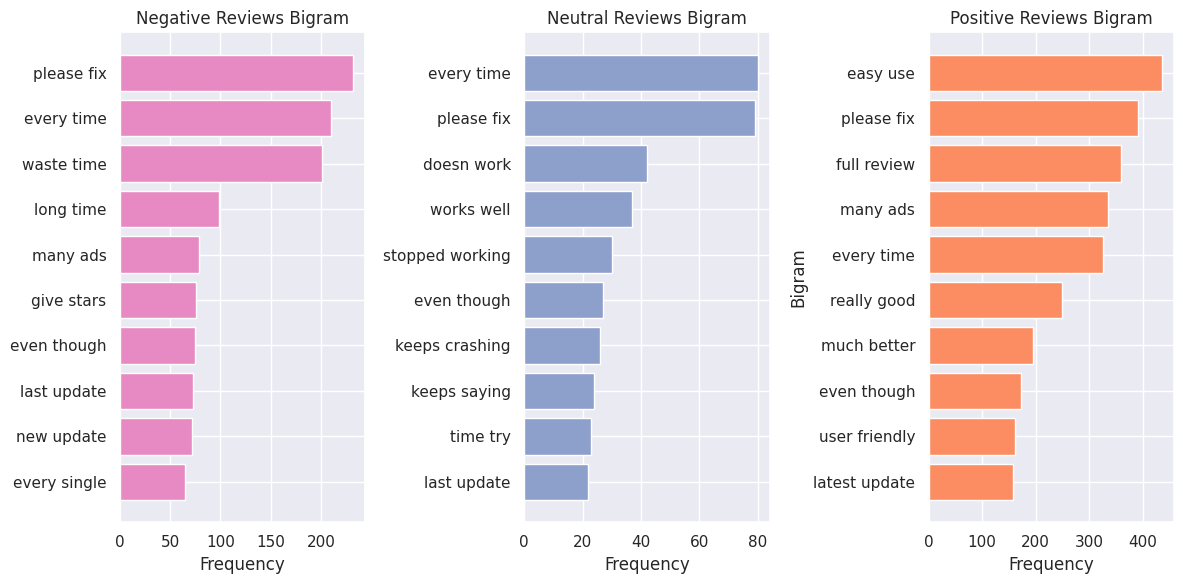

In [ ]:
#We create a figure with three subplots,
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)


#we sort the negative dataframe by frequency,
Negative.sort_values(by=['frequency'],inplace=True)

#we plot the negative dataframe in the form of a horizontal bar.
ax1.barh(Negative['ngram'].values,Negative['frequency'].values,color=cmap3(3))
ax1.set_xlabel('Frequency')
ax1.set_title('Negative Reviews Bigram')



#We make analogous for the neutral dataframe,
dfNeutr.sort_values(by=['frequency'],inplace=True)

ax2.barh(dfNeutr['ngram'].values,dfNeutr['frequency'].values,color=cmap3(2))
ax2.set_xlabel('Frequency')
ax2.set_title('Neutral Reviews Bigram')



#the analogue for the neutral dataframe,
dfpositive.sort_values(by=['frequency'],inplace=True)

ax3.barh(dfpositive['ngram'].values,dfpositive['frequency'].values,color=cmap3(1))
ax3.set_ylabel('Bigram')
ax3.set_xlabel('Frequency')
ax3.set_title('Positive Reviews Bigram')

#we select the size and Adjust the padding between and around the subplots.
fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()


In these Bigrams, there seems to be agreement with the previous graph, however, we noticed that in both the positive, negative and neutral bigrams we have the sequence please fix, this could refute that the positive reviews are not positive, or that the user liked the app and gave it a rating good, although I found some problems in the app. That's why we'll show you one of these positive reviews:

In [ ]:
# creating and passing series to new column,
findtext = user_reviews_copy[user_reviews_copy['Sentiment']=='Positive'].copy()

substring = 'please fix'

#we find the columns with the word 'please fix'
findtext['found_text'] = findtext['Translated_Review'].str.contains(substring, case=True, flags=0, na=None, regex=True)

#and we select all columns that contain the string 'please fix'.
aux = findtext[findtext['found_text']==True]

After selecting these columns, we take an example that has the sequence 'please fix'.

In [ ]:
aux['Translated_Review'][1098]

'so far i like it  the options talk  get help connect great  however qite bugs glitches  i m sure upgrade would offer wouldnt consider bugs worked out  this great idea could help many people  please fix bugs '

It seems that's right, the user liked the app despite bugs.

### 6.4 - Named entity recognition

Now we want to classify our text in some entities, such as countries, buildings, dates, institutions, etc., this will become clearer with the example, in addition to performing the operation we will again use spacy. Before anything else, we will glimpse all the entities that the model can classify and their description.

In [ ]:
import spacy

#we initialize the model using English,
nlp = spacy.load( "en_core_web_sm" )

#we took the labels,
labels = nlp.get_pipe("ner").labels

#we collect the description of each entity, 
desc=[spacy.explain(i) for i in labels]

#and create a dataframe with entity and entity description to understand better.
mydf = pd.DataFrame({'Entity': labels,
     'Description': desc
    })

we show all the following entities:

In [ ]:
mydf

,Entity,Description
0,CARDINAL,Numerals that do not fall under another type
1,DATE,Absolute or relative dates or periods
2,EVENT,"Named hurricanes, battles, wars, sports events..."
3,FAC,"Buildings, airports, highways, bridges, etc."
4,GPE,"Countries, cities, states"
5,LANGUAGE,Any named language
6,LAW,Named documents made into laws.
7,LOC,"Non-GPE locations, mountain ranges, bodies of ..."
8,MONEY,"Monetary values, including unit"
9,NORP,Nationalities or religious or political groups


with the terrain ready we will extract the entities from our data for each sentiment class.

In [ ]:
#we create a dataframe for each feeling
positivedf = user_reviews_copy[user_reviews_copy['Sentiment']=='Positive']
neutraldf = user_reviews_copy[user_reviews_copy['Sentiment']=='Neutral']
negativedf = user_reviews_copy[user_reviews_copy['Sentiment']=='Negative']


#we create a function that generates a doc variable, which contains an instance with the entities and from it we extract the entities
def ner(text):
    doc=nlp(text, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])
    return [u.label_ for u in doc.ents]


# we apply the above function to a fraction of our data, finally
#since not every word has an entity, so we delete all null entities and collect the ones we want
entp=positivedf['Review_without_stopwords'][:900].\
    apply(lambda u : ner(u))
entp=[u for sub in entp for u in sub]

#we count the words, then we take the most common ones and finally we take the words and word frequencies in two lists 
countp=Counter(entp).most_common(7)
px, py = list(zip(*countp))[0], list(zip(*countp))[1]



#we do the same operation as before but with neutral sentiment
entn=neutraldf['Review_without_stopwords'][:900].\
    apply(lambda u : ner(u))
entn=[u for sub in entn for u in sub]

countern=Counter(entn).most_common(7)
nx, ny = list(zip(*countern))[0], list(zip(*countern))[1]



#we do the same operation as before but with negative sentiment
entM=negativedf['Review_without_stopwords'][:900].\
    apply(lambda u : ner(u))
entM=[u for sub in entM for u in sub]

counterM=Counter(entM).most_common(7)
Mx, My = list(zip(*counterM))[0], list(zip(*counterM))[1]


We plot the fraction of entities in each sentiment, as the `NER` operation takes a lot of time on large data:

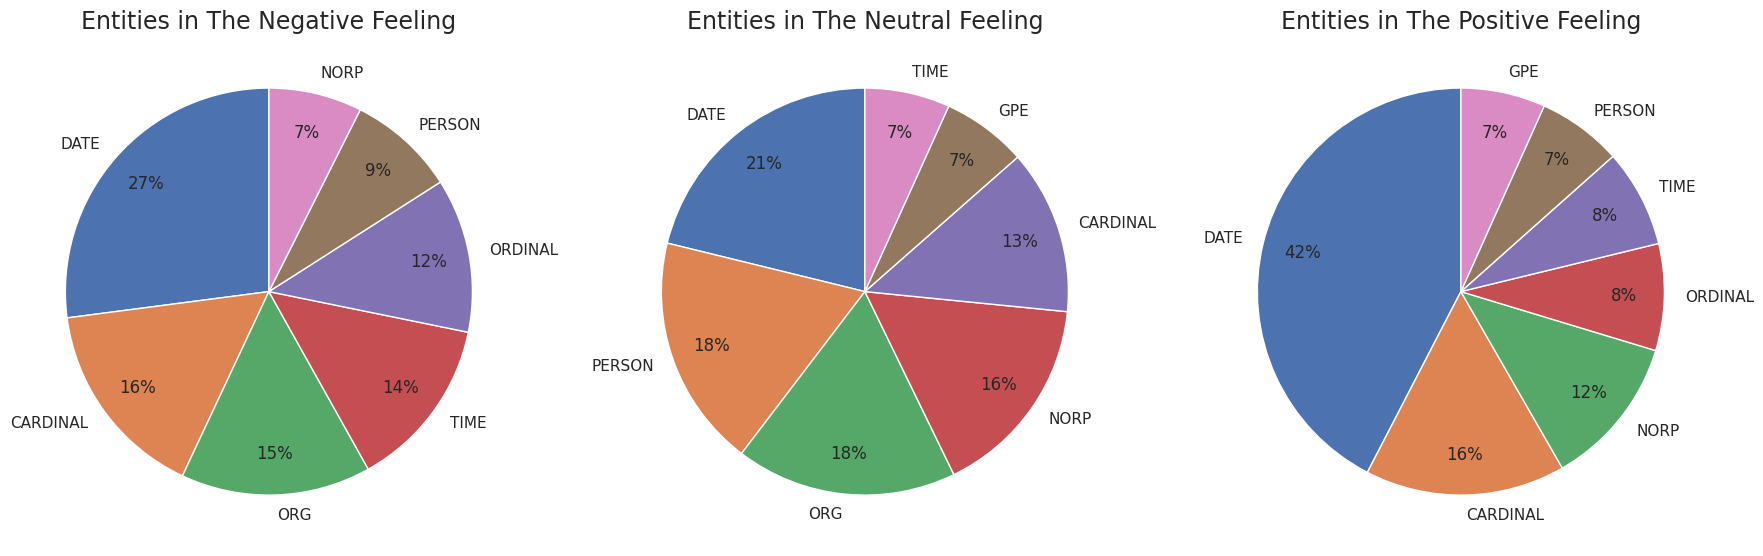

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)

#we create dataframes with the entities and frequencies 
positivedfm = pd.DataFrame(list(zip(px,py)), columns = ['Entity','frequency'])
Neutrdfm = pd.DataFrame(list(zip(nx,ny)), columns = ['Entity','frequency'])
Negativedfm = pd.DataFrame(list(zip(Mx,My)), columns = ['Entity','frequency'])


#we select only the first 8 entities and we plot graphs with the percentage of each entity
Negativedfm = Negativedfm[:8]
ax1.pie(Negativedfm['frequency'].values,labels=Negativedfm['Entity'].values,shadow=False, startangle=90,autopct='%1.0f%%',pctdistance=0.8)
ax1.set_title('Entities in The Negative Feeling',fontsize = 17)


#we are the similar with the first 7 entities
Neutrdfm = Neutrdfm[:7]
ax2.pie(Neutrdfm['frequency'].values,labels=Neutrdfm['Entity'].values,shadow=False, startangle=90,autopct='%1.0f%%',pctdistance=0.8)
ax2.set_title('Entities in The Neutral Feeling',fontsize = 17)


#the same with the first 8 positive class entities
positivedfm = positivedfm[:8]
ax3.pie(positivedfm['frequency'].values,labels=positivedfm['Entity'].values,shadow=False, startangle=90,autopct='%1.0f%%',pctdistance=0.8)
ax3.set_title('Entities in The Positive Feeling',fontsize = 17)


fig.set_size_inches(18, 18)
fig.tight_layout()
plt.show()

In this small part of the data, we find in the negative sentiment more data on data, cardinals and companies, agencies and institutions, whereas in the neutral class data, the only difference from the negative class is that we also have data about people. Finally, in the positive class data, we find more data on date, cardinals and religions/nationalities.

### 6.5 - Preparing the data

We are almost done with the exploratory data analysis part, now we are going to operate our data only through the 'Translated_Review' and 'Sentiments' columns. We will go back to our original dataset and change the labels from text to number, as well as set the sentiment of our data to two types, 1 will mean positive sentiment, 0 will define negative sentiment. Also, we will make the neutral feeling of the negative type, as we have a lot of positive feelings.

In [ ]:
# We copy the data for preservation,
DF_ForPrediction = googleplaystore_user_reviews.copy()

# we apply the modifications mentioned above,
DF_ForPrediction['sentiments'] = DF_ForPrediction.Sentiment.\
          apply(lambda x : 1 if x == 'Positive' else (0 if (x == 'Negative' or x == 'Neutral') else np.nan)).astype('Int64')

# remove unnecessary columns.
DF_ForPrediction.drop(['Sentiment_Polarity','Sentiment_Subjectivity','App'], axis=1,inplace=True)

After this procedure we remove the NAN data from our dataset.

In [ ]:
DF_ForPrediction.dropna(subset=["sentiments"], how="all", inplace=True)

We don't divide the labels into positive, neutral and negative, because the code is too slow as we have to apply different techniques for multiclass classification, such as Flatten and BatchNormalization layers, but we don't implement multiclass. To see if our data was preserved we use the `.value_counts()` method.

In [ ]:
DF_ForPrediction['sentiments'].value_counts()

1    23998
0    13434
Name: sentiments, dtype: Int64

In [ ]:
googleplaystore_user_reviews['Sentiment'].value_counts()

Positive    23998
Negative     8271
Neutral      5163
Name: Sentiment, dtype: int64

With these results we noticed agreement in the data, since adding the neutral and negative labels we get 13434 labels.

### 6.6 - Splitting the data into Training and Testing

After we remove our labels we can split them into training and text, for this operation we take 75% of our data for training, 10% for testing and validation.

In [ ]:
import math 



#number of row to train the model
training_data_len = math.ceil(len(DF_ForPrediction) * .75)

#intermediate step
another = math.ceil(len(DF_ForPrediction) - training_data_len)/2

#final limit for validation and initial limit for testing
finalAnother = math.ceil(training_data_len + another)

#split
train_reviews =  DF_ForPrediction['Translated_Review'][:training_data_len].copy().to_numpy().astype(str)
train_label = DF_ForPrediction['sentiments'][:training_data_len].copy().to_numpy().astype(int)


valid_reviews = DF_ForPrediction['Translated_Review'][training_data_len:finalAnother].copy().to_numpy().astype(str)
valid_label = DF_ForPrediction['sentiments'][training_data_len:finalAnother].copy().to_numpy().astype(int)



test_reviews = DF_ForPrediction['Translated_Review'][finalAnother:].copy().to_numpy().astype(str)
test_label =  DF_ForPrediction['sentiments'][finalAnother:].copy().to_numpy().astype(int)

print('To verify that there is no data leakage, we will show the first and last data of each of these divisions.:\n')
print(train_reviews[0], '\n', train_reviews[-1],'\n\n', valid_reviews[0], '\n', valid_reviews[-1],
      '\n\n', test_reviews[0], '\n', test_reviews[1])


To verify that there is no data leakage, we will show the first and last data of each of these divisions.:

I like eat delicious food. That's I'm cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)" 
 ok Is ok I play mom I lose 100000 times win like 20000000 well I need 

 Fab. No ads easy 
 This great app. My complaint leave NFC order make payment. I wish Google would something similar Samsung Pay slide finger bottom prefer card shows automatically turns NFC turns off. 

 Good idea let verify card use, I using Samsung pay I Samsung recently upgraded different brand, I loved Samsung pay. Never problems adding card anything. I like able phone pay I'm disappointed let add card. If would let add card, obviously I would add stars. All disappointed. 
 I changing review amount problems I google pay. To start I try link debit credit cards none work banks supported. I cant cards google play. Whereas Apple Pay credit cards supported. I thought I would link pay pa

Having divided the data into training and testing, we are now going to define some parameters that will be applied to our model, in this way we only take a few words from the vocabulary to train our model (vocab_size = 9352), as it is enough. Furthermore we assume that each review must have a fixed length of 180 words (max_length = 180), which means that if a comment is longer than 180 words it will be truncated to 180 words, if the comment is less than 180 words it will be padded of zeros, as we are going to tokenize the words (more on that later). At the end of the cell, we define the size of the output vectors of a layer (Embedding) for each word, to have 200 dimensions, such a layer will be created later.


In [ ]:
vocab_size = 9352


max_length = 180 


embedding_dim = 200


In some references, some authors report that there is a rule to define the values above, however, as I will use a grid search, in the future I will test several values, with the objective of verifying in which of them the model behaves better.

### 6.7 - Cleaning, standardizing and tokenizing with TextVectorization

We got to one of the most interesting parts of NLP, which is tokenization, we've done this before using sklearn's CountVectorizer, but we don't clearly explain the procedure. This was done due to the fact that we would like to use another processing method which is called keras preprocessing layer of Text Vectorization. Before that, let's create a preprocessor function to be used in TextVectorization, which throws out everything that is not a character and changes the token from UNK to True.

In [ ]:

import string
@tf.keras.utils.register_keras_serializable()
def custom_standardization(initial_string):
    """ Remove everything that is not a character or string in the data """

    no_uppercased = tf.strings.lower(initial_string, encoding='utf-8')

    Aux_data = tf.strings.regex_replace(no_uppercased, rb"<br\s*/?>", b" ")

    change_token = tf.strings.regex_replace(Aux_data, "[UNK]", b"True")

    Clean_data = tf.strings.regex_replace(change_token, b"[^a-zA-Z']", b" ")    
    
    no_punctuations = tf.strings.regex_replace(Clean_data, f"([{string.punctuation}])", r" ")


    return no_punctuations
    

Here we do not remove the stop words, because after running the program a few times we realize that such removal does not add significant relevance to the model. Therefore we define the `TextVectorization` layer having a vocabulary of 9352 words, truncation of 180 words, a vector space of word embedding of 200 dimensions, and our preprocessing function created above. The TextVectorization method encodes words into integers, whose operation is meant to look for words in the text and map them to distinct ids.

In [ ]:
from tensorflow.keras.layers import TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize = custom_standardization,
    output_mode="int",
    output_sequence_length=max_length,
)


Having created the `vectorize_layer` layer we can create the vocabulary by applying the `.adapt()` method to the training data.

In [ ]:
vectorize_layer.adapt(train_reviews)

We also need to make our data to be tensors, as tensorflow is best implemented with tensors, despite accepting numpy array as input. For this purpose, just changing the dimension of the data with `expand_dims()` makes the numpy array tensor.

In [ ]:
train_ds = tf.expand_dims(train_reviews,-1)
test_ds = tf.expand_dims(test_reviews,-1)
valid_ds = tf.expand_dims(valid_reviews,-1)


labelsTrain = tf.expand_dims(train_label,-1)
labelsTest = tf.expand_dims(test_label,-1)
labelValid = tf.expand_dims(valid_label,-1)

Some models expect a 3D input (nSamples,NTimesteps,NFeatures) and since our `train_ds` and `train_ds` is two-dimensional, let's reshape it.



In [ ]:
train_ds = tf.reshape(train_ds, (train_ds.shape[0],train_ds.shape[1],1))

test_ds = tf.reshape(test_ds, (test_ds.shape[0],test_ds.shape[1],1))

valid_ds = tf.reshape(valid_ds, (valid_ds.shape[0],valid_ds.shape[1],1))#

## 7 - Choose and Train The Model

In this step, we will analyze several models to find the best one for our project, but first we will define the `callbacks.ModelCheckpoint()` method that saves the best model in checkpoints at the end of each epoch. We will also apply the `callbacks.EarlyStopping()` method, which suspends the training when there is no evolution in the validation after three epochs (number of times the algorithm will go through the training data). In both methods we use `mode='min'` (since we look for the minimum for loss between the desired output and the current output of the network, in the validation data) and `monitor='val_loss'`, as we want to monitor the loss in the validation set.

In [ ]:
from tensorflow import keras

#We define the folder where the model will reside,
Model_PATH = os.path.join("Sentiment_Analysis", "Model")
if not os.path.isdir(Model_PATH):
    os.makedirs(Model_PATH)

# we use save_best_only=True to save the model,
save_model_cb = keras.callbacks.ModelCheckpoint("/content/Sentiment_Analysis/Model/best_model.tf", save_best_only=True,mode='min',monitor='val_loss')

#we put restore_best_weights=True, so that the model weights are restored at the time
#with the best result of the monitored measurement
stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=3,
                                                  restore_best_weights=True)


### 7.1 - Baseline Embedding model

#### 7.1.1 - Creating the Embedding Neural Network

Finally, it's time to create our neural network, usually the first model should be the one that will be used to compare with the other models, to check which one is the best. So I'll start with a simple model, but I'll add some techniques that will make the model have a good rating. Neural networks are based on biological neurons and can make predictions from input data, because they are based on biological neurons that enjoy layers, neural networks have input layers, fully connected layers and output layers. Such layers have nodes that are neurons that connect with other neurons, if the neuron reaches a threshold value, it will be turned on, taking information to the next layer of the network, if this does not occur, there will be no data transmission.


In our neural network we use `Sequential()` to assemble the layers in a `ctf.keras.Model` file into a linear stack, the first layer we add is to ensure that there is exactly one input string per batch, the next is the preprocessing layer already created. Continuing in our network, we create an `embedding` layer (Transforms positive integers (indices) into fixed-length dense vectors.) taking as input the parameters already explained in section `6.6`. The next layer we add is `GlobalAveragePooling1D()`, which in the 2D case is usually applied to images to reduce resolution or computational load, but in our case we can use this to decrease the number of trainable parameters. I didn't use `Flatten` because with Pooling1D we got better scores.


Therefore, we use a regularization technique called `Dropout`, which basically skips some neurons with 10% rate during training, but can be activated in a later step. Next, we use dense layers that link the neurons of a layer, with previous layers, and apply the weight initializer, which sets the weights of a neural network to short random values, in addition to determining kick-off to optimize the neural network model. In our model we use the `He` initialization which takes an arbitrary number whose probability distribution is the Gaussian, with standard deviation ($√2/n$) , such that $n$ is the number of connections of a response in the layers and average of 0.0.

Furthermore, we employ what we call the activation function, which determines the way in which the weighted sum of the neural network input is converted into an output of nodes in a layer of the network. The activation function we use is `PreLU`, which adapts as it understands the parameters of the rectifiers, and improves accuracy with negligible additional computational cost. But what is a rectifier? Basically, a linear rectified activation unit is a unit or node, which elaborates the activation function reported above, therefore, rectified networks are those that benefit from the rectifier function for the hidden layers. Finally, we use an output neuron and a sigmoid activation function, where `sigmoid` is a logistic function whose result can be 0 or 1 (0 dissatisfied with application, 1 satisfied).


References:

https://arxiv.org/abs/1502.01852

https://arxiv.org/abs/1505.00853


http://robotics.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf


In [ ]:
import tensorflow as tf
from tensorflow import keras

modelEmbedding = keras.Sequential([
    keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
        ),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dropout(rate=0.1),

    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),

    keras.layers.Dense(1, activation="sigmoid")
])


#### 7.1.2 - Compiling and tuning and evaluating the Embedding model

In neural network models we must compile the model, to initially configure loss functions, optimizers and which metrics will be applied to it. The optimizer we use is Adam which is based on momentum, momentum aggregates exponentially declining moving averages from previous gradients and proceeds to move towards it. The Adam optimizer, on the other hand, measures individual learning rates that adapt to different parameters, through approximations of the first and second moments of the gradients. In addition we use what we call a loss function, a loss function returns error values, that is, the smaller the better, the loss function we will use is the binary cross entropy, which tells us an exit probability between zero and one , moreover such loss function grows as predicted probability diverges from the present label. Finally, we use accuracy as an auxiliary metric.



references:

GOODFELLOW; BENGIO, Y.; COURVILLE, A. Deep Learning (Adaptive Computation and Machine Learning series). 1ª. ed. Massachusetts: MIT Press, 2016.

ATSAT, H.; PURI, S.; LOOKABAUGH, B. Machine Learning and Data Science
Blueprints for Finance: From Building Trading Strategies to Robo-Advisors Using Python. 1ª. ed. United States of America.: O’Reilly, 2020.


MIRTAHERI, S. L.; SHAHBAZIAN, R. Machine Learning: Theory to Applications. 1ª. ed. Florida - USA: CRC Press, 2022. 

In [ ]:
from tensorflow.keras.optimizers import Adam

def CompileAndFit(Mymodel,Xtrain,Ytrain, Xvalid,Yvalid):

  #we define the optimizer
  optimizer = keras.optimizers.Adam(learning_rate=0.003)

  #we compile the model
  Mymodel.compile(loss="binary_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])


  #we adjusted the model to 5 epochs, with validation data and the checkpoint/early_stopping
  num_epochs = 5
  Mymodel.fit(Xtrain,Ytrain, epochs=num_epochs,validation_data=(Xvalid,Yvalid),callbacks=[save_model_cb,stop_cb])

  return Mymodel

Above we created a function, because we are going to compile and adjust the model several times, after such an operation, in addition to calling the `CompileAndFit()` function, we will also count the compilation time of the models to compare them.

In [ ]:
import time 

#timer
inicioOne = time.time()

#first model
modelOne = CompileAndFit(modelEmbedding,train_ds, labelsTrain, valid_ds,labelValid)

#end of time count
fimOne = time.time()

Epoch 1/5
878/878 [==============================] - 12s 9ms/step - loss: 0.4278 - accuracy: 0.7945 - val_loss: 0.2979 - val_accuracy: 0.8825
Epoch 2/5
878/878 [==============================] - 7s 8ms/step - loss: 0.1901 - accuracy: 0.9326 - val_loss: 0.2654 - val_accuracy: 0.9075
Epoch 3/5
878/878 [==============================] - 6s 6ms/step - loss: 0.1386 - accuracy: 0.9529 - val_loss: 0.3091 - val_accuracy: 0.9004
Epoch 4/5
878/878 [==============================] - 6s 6ms/step - loss: 0.1137 - accuracy: 0.9605 - val_loss: 0.3559 - val_accuracy: 0.8959
Epoch 5/5
878/878 [==============================] - 6s 6ms/step - loss: 0.0943 - accuracy: 0.9676 - val_loss: 0.3267 - val_accuracy: 0.9036


In [ ]:
from math import fabs

print("Embedding Runtime:",fabs(inicioOne - fimOne), "s")

Embedding Runtime: 35.60328555107117 s


In [ ]:
#evaluation
evaluationEmb = modelOne.evaluate(test_ds,labelsTest)

147/147 [==============================] - 0s 3ms/step - loss: 0.2493 - accuracy: 0.9083


Seems pretty good!

### 7.2 - Model With LSTM

In this model, if we use the embedding layer with the parameter `mask_zero=True`, we can improve the loss function a lot, but the model's performance is terrible if we do that. I say this because I tried to insert several parameters in the lstm layer like `activation`, `recurrent_activation`, `recurrent_dropout`, `use_bias` and `reset_after`, but even then the model was very slow.

#### 7.2.1 - Creating the neural network with LSTM layer

After going through the Embedding model we can create another model with small differences, for this purpose we will remove the `GlobalAveragePooling1D` layer and add an LSTM layer with 200 neurons. A Long Short-Term Memory (LSTM) neural network is a recurrent neural network (RNN) architecture that has cells that can understand and identify an important input, contain it in the long-term state, retain it for the desired time, and remove it when desired. Thus, an LSTM unit has an entry gate, an oblivion gate, and an exit gate.


In [ ]:
modelTwo =  keras.Sequential([
            keras.Input(shape=(1,), dtype=tf.string),
            vectorize_layer,
            keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
        ), 

    keras.layers.LSTM(200),                
    keras.layers.Dropout(rate=0.1),

    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    
    keras.layers.Dense(1, activation='sigmoid')
])


#### 7.2.2 - Compiling and Evaluating LSTM

We do similar to what we did before, but with a different model.

In [ ]:
import time 

#timer
inicioTwo = time.time()

#second model
modelTwo = CompileAndFit(modelTwo,train_ds, labelsTrain,  valid_ds,labelValid)

#end of time count
fimTwo = time.time()

Epoch 1/5
878/878 [==============================] - 19s 17ms/step - loss: 0.6550 - accuracy: 0.6409 - val_loss: 0.6509 - val_accuracy: 0.6446
Epoch 2/5
878/878 [==============================] - 14s 16ms/step - loss: 0.6534 - accuracy: 0.6414 - val_loss: 0.6511 - val_accuracy: 0.6446
Epoch 3/5
878/878 [==============================] - 14s 16ms/step - loss: 0.6545 - accuracy: 0.6412 - val_loss: 0.6508 - val_accuracy: 0.6446
Epoch 4/5
878/878 [==============================] - 14s 16ms/step - loss: 0.6530 - accuracy: 0.6414 - val_loss: 0.6507 - val_accuracy: 0.6446
Epoch 5/5
878/878 [==============================] - 14s 16ms/step - loss: 0.6526 - accuracy: 0.6414 - val_loss: 0.6508 - val_accuracy: 0.6446


In [ ]:
from math import fabs

print("LSTM Runtime:",fabs(inicioTwo - fimTwo), "s")

LSTM Runtime: 74.7329614162445 s


In [ ]:
#evaluation
evaluationLSTM = modelTwo.evaluate(test_ds,labelsTest)

147/147 [==============================] - 1s 7ms/step - loss: 0.6561 - accuracy: 0.6358


### 7.3 - Model With GRU 

A Gru layer (gated recurrent units) is very similar to LSTM, their main difference is that they have two ports, one for update and one for reset, while the lstm unit has 3 ports. The reset port groups the current input with the memory, the refresh port establishes the memory.

#### 7.3.1 - Creating the GRU Neural Network

To create the neural network in this case we do something very similar to what was done before, the diderential is the GRU layer. Here again if we used `mask_zero=True` we would have so much better accuracy, when the loss function would be better, but the computational cost is so great it's not worth it.

In [ ]:
modelTree = keras.Sequential([
            keras.Input(shape=(1,), dtype=tf.string),
            vectorize_layer,
            keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
        ), 
    keras.layers.GRU(200),       
    keras.layers.Dropout(rate=0.1),
    
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),

    keras.layers.Dense(1, activation='sigmoid')
])

#### 7.3.2 - Compiling and Evaluating GRU

We compile the model by calling the compile function

In [ ]:
import time 

#timer
inicioTree = time.time()

#terceiro modelo
modelTree = CompileAndFit(modelTree,train_ds, labelsTrain, valid_ds,labelValid)

#end of time count
fimTree = time.time()

Epoch 1/5
878/878 [==============================] - 17s 17ms/step - loss: 0.6553 - accuracy: 0.6412 - val_loss: 0.6508 - val_accuracy: 0.6446
Epoch 2/5
878/878 [==============================] - 14s 16ms/step - loss: 0.6534 - accuracy: 0.6414 - val_loss: 0.6508 - val_accuracy: 0.6446
Epoch 3/5
878/878 [==============================] - 14s 16ms/step - loss: 0.6531 - accuracy: 0.6414 - val_loss: 0.6512 - val_accuracy: 0.6446
Epoch 4/5
878/878 [==============================] - 14s 16ms/step - loss: 0.6538 - accuracy: 0.6412 - val_loss: 0.6518 - val_accuracy: 0.6446


In [ ]:
from math import fabs

print("GRU Runtime:",fabs(inicioTree - fimTree), "s")

GRU Runtime: 59.2954683303833 s


In [ ]:
#evaluation
evaluationGRU = modelTree.evaluate(test_ds,labelsTest)

147/147 [==============================] - 1s 9ms/step - loss: 0.6558 - accuracy: 0.6358


### 7.4 - Simple RNN Model

In a simple recurrent neural network, information is processed in a similar way for each element in a sequence, so that in order to have results in the output, past calculations must be performed. Here we simply add one each simple RNN.

#### 7.4.1 - Creating the RNN neural network

Here we build a neural network very similar to the previous ones, the difference is the insertion of the SimpleRNN layer.

In [ ]:
import tensorflow as tf

modelFour = keras.Sequential([
            keras.Input(shape=(1,), dtype=tf.string),
            vectorize_layer,
            keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
        ),
    tf.keras.layers.SimpleRNN(200),
    keras.layers.Dropout(rate=0.1),
    
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.1),
    keras.layers.PReLU(),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])


#### 7.4.2 - Compiling and Evaluating the RNN

we compile the model:

In [ ]:
import time 

#timer
inicioFour = time.time()

#third model
modelFour = CompileAndFit(modelFour,train_ds, labelsTrain, valid_ds,labelValid)

#end of time count
fimFour = time.time()

Epoch 1/5
878/878 [==============================] - 163s 184ms/step - loss: 0.6577 - accuracy: 0.6403 - val_loss: 0.6507 - val_accuracy: 0.6446
Epoch 2/5
878/878 [==============================] - 156s 178ms/step - loss: 0.6537 - accuracy: 0.6414 - val_loss: 0.6508 - val_accuracy: 0.6446
Epoch 3/5
878/878 [==============================] - 162s 184ms/step - loss: 0.6531 - accuracy: 0.6414 - val_loss: 0.6508 - val_accuracy: 0.6446
Epoch 4/5
878/878 [==============================] - 160s 182ms/step - loss: 0.6528 - accuracy: 0.6414 - val_loss: 0.6513 - val_accuracy: 0.6446


In [ ]:
from math import fabs

print("RNN Runtime:",fabs(inicioFour - fimFour), "s")

RNN Runtime: 641.0944693088531 s


In [ ]:
#evaluation
evaluationSRNN = modelFour.evaluate(test_ds,labelsTest)

147/147 [==============================] - 2s 16ms/step - loss: 0.6561 - accuracy: 0.6358


### 7.5 - Comparing the models

We already know that the first neural network created is the best, but even so, we are going to show the results here, so we illustrate the times of the models below:

In [ ]:
print("Embedding Runtime:",fabs(inicioOne - fimOne), "s")
print("LSTM Runtime:",fabs(inicioTwo - fimTwo), "s")
print("GRU Runtime:",fabs(inicioTree - fimTree), "s")
print("RNN Runtime:",fabs(inicioFour - fimFour), "s")

Embedding Runtime: 35.60328555107117 s
LSTM Runtime: 74.7329614162445 s
GRU Runtime: 59.2954683303833 s
RNN Runtime: 641.0944693088531 s


and their respective loss functions:

In [ ]:
print('Embedding: Loss {} , accuracy {}'.format(evaluationEmb[0], evaluationEmb[1]))
print('LSTM: Loss {} , accuracy {} '.format(evaluationLSTM[0], evaluationLSTM[1]))
print('GRU: Loss {} , accuracy {} '.format(evaluationGRU[0], evaluationGRU[1]))
print('SRNN: Loss {} , accuracy {} '.format(evaluationSRNN[0], evaluationSRNN[1]))

Embedding: Loss 0.24928568303585052 , accuracy 0.9083137512207031
LSTM: Loss 0.6561262607574463 , accuracy 0.6358196139335632 
GRU: Loss 0.6558085083961487 , accuracy 0.6358196139335632 
SRNN: Loss 0.6560606956481934 , accuracy 0.6358196139335632 


## 8 - Trying to perfect the best model

Now let's try to improve the best model using a library called scikeras:

In [ ]:
!pip install scikeras==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 8.1 - Randomized Search 

Through the library above we can use a grid search to find the best hyperparameters in our model. To use the grid search we will encapsulate our model in objects, which try to reproduce the skid learn classifiers. Let's develop a function that creates and compiles a keras model keeping in mind several hyperparameters. The following function is very similar to the first model we built, the big difference is that by default we put only a dense layer with the regularizations. The intention of this neural network is to classify the text in a binary way, and in our model we did not insert the `TextVectorization` layer due to the fact that it results in errors since we are using a wrapper.

In [ ]:
from numpy.random.mtrand import random_integers
initializer = tf.keras.initializers.HeNormal()

m = tf.keras.metrics.RootMeanSquaredError()

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-2,
                vocab_size=vocab_size, 
                embedding_dim=128,
                activation="sigmoid",
                rate=0.1):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_length))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dropout(rate=rate))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, kernel_initializer=initializer))
        model.add(keras.layers.Dropout(rate=rate))
        model.add(keras.layers.PReLU())
    model.add(keras.layers.Dense(1, activation))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=['accuracy'])
    return model

In addition to this operation we must change the data dimension with `expand_dims()` and apply the preprocessing layer by hand to avoid errors.

In [ ]:
def to_tensor_vectorize(text):
  result = np.expand_dims(text,-1)
  return vectorize_layer(result)

Before using our model we must make the tensors to be numpy arrays, this will be done, because our classifier uses some features of sckid learn, which is not so used to tensors and gives a lot of error if we insert tensors even with a well defined shape , soon I will transform tensors into numpy arrays.

In [ ]:
#X train
axuOne = to_tensor_vectorize(train_reviews) #treatment through the TextVectorization layer
X_train = tf.constant(axuOne) #we create a constant tensor like this intermediate step
X_train_final = np.array(X_train).astype('int64')#we make the tensor become a numpy array
X_train_final = np.reshape(X_train_final, (X_train_final.shape[0],X_train_final.shape[1],1))# we change the shape

#y train
#labels = tf.constant(labelsTrain)#we create a constant tensor like this intermediate step
lb_trainFinal = np.array(labelsTrain).astype('int64')#we make the tensor become a numpy array


#We do the same above with the x test and y test
#X test
axuTwo = to_tensor_vectorize(test_reviews)
X_test = tf.constant(axuTwo)
X_test_final = np.array(X_test).astype('int64')
X_test_final = np.reshape(X_test_final, (X_test_final.shape[0],X_test_final.shape[1],1))


#y test
#labelsT = tf.constant(labelsTest)
lb_testFinal = np.array(labelsTest).astype('int64')


#the same for validation
axuTwo = to_tensor_vectorize(valid_reviews)
X_valid = tf.constant(axuTwo)
X_valid_final = np.array(X_valid).astype('int64')
X_valid_final = np.reshape(X_valid_final, (X_valid_final.shape[0],X_valid_final.shape[1],1))


#y valid
#labelsVa = tf.constant(labelValid)
lb_ValidFinal = np.array(labelValid).astype('int64')




After all this process we create a keras classifier using the `build_model()` function, so the created keras object can be implemented in the same way as a skid learn classifier, that is, we can use the `fit()` and `predict( )`.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import RandomizedSearchCV
import numpy
from scikeras.wrappers import KerasClassifier
import random

#We define a list of neurons for the search,
random.seed(17)
n_neurons = [random.randint(1,300) for i in range(0,6)][3:]


#we create the KerasClassifier object,
model = KerasClassifier(model=build_model,n_hidden=1, n_neurons=30,learning_rate=3e-2,
                vocab_size=vocab_size, 
                embedding_dim=128,
                activation="sigmoid",
                rate=0.1)

#we select all the parameters that we want to compare.
param_distribs = {
    "n_hidden": [0, 2, 3],
    "embedding_dim": [10, 50, 128],
    "n_neurons": n_neurons,
    "rate": [0.1,0.2,0.3],
    "learning_rate": [3e-1,3e-3,3e-4],
    
     
}


#We use random search because it is faster than grid search,
grid = RandomizedSearchCV(estimator=model, param_distributions=param_distribs, n_iter=5, cv=5,
                          verbose=2,scoring='accuracy',random_state=42,
                          )


num_epochs = 5

#we fit the model.
grid_result = grid.fit(X_train_final,lb_trainFinal, epochs=num_epochs,
                       validation_data=(X_valid_final,lb_ValidFinal),
                       callbacks=[save_model_cb, stop_cb])



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Epoch 1/5
702/702 [==============================] - 6s 7ms/step - loss: 107.9958 - accuracy: 0.6084 - val_loss: 0.6251 - val_accuracy: 0.6715
Epoch 2/5
702/702 [==============================] - 6s 9ms/step - loss: 0.5993 - accuracy: 0.7002 - val_loss: 0.6060 - val_accuracy: 0.7059
Epoch 3/5
702/702 [==============================] - 6s 9ms/step - loss: 0.4736 - accuracy: 0.7841 - val_loss: 0.5883 - val_accuracy: 0.7465
Epoch 4/5
702/702 [==============================] - 7s 10ms/step - loss: 0.3656 - accuracy: 0.8514 - val_loss: 0.6714 - val_accuracy: 0.7779
Epoch 5/5
176/176 [==============================] - 1s 3ms/step
[CV] END embedding_dim=10, learning_rate=0.3, n_hidden=3, n_neurons=90, rate=0.1; total time=  32.7s
Epoch 1/5
702/702 [==============================] - 5s 6ms/step - loss: 101.3851 - accuracy: 0.5814 - val_loss: 0.7412 - val_accuracy: 0.6446
Epoch 2/5
702/702 [==============================] - 4s 5ms/step

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.901475 using {'rate': 0.2, 'n_neurons': 149, 'n_hidden': 3, 'learning_rate': 0.0003, 'embedding_dim': 128}


In [ ]:
grid_model = grid_result.best_estimator_.model_
grid_model

In [ ]:
grid_model.evaluate(X_test_final,test_label)

147/147 [==============================] - 1s 3ms/step - loss: 0.2732 - accuracy: 0.9094


[0.27324748039245605, 0.9093823432922363]

### 8.2 - Final Model

Now that we have the best model, let's create the neural network again, as for some reason keras classifier doesn't work with a text vectorization layer.

In [ ]:
end_to_end_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    grid_model,
])

We recompile and tweak the final model.

In [ ]:
end_to_end_model = CompileAndFit(end_to_end_model,train_ds, labelsTrain, valid_ds,labelValid)

Epoch 1/5
878/878 [==============================] - 10s 9ms/step - loss: 0.1777 - accuracy: 0.9330 - val_loss: 0.2835 - val_accuracy: 0.9028
Epoch 2/5
878/878 [==============================] - 7s 8ms/step - loss: 0.1450 - accuracy: 0.9447 - val_loss: 0.3345 - val_accuracy: 0.8989
Epoch 3/5
878/878 [==============================] - 6s 7ms/step - loss: 0.1232 - accuracy: 0.9543 - val_loss: 0.3265 - val_accuracy: 0.9015
Epoch 4/5
878/878 [==============================] - 6s 7ms/step - loss: 0.1109 - accuracy: 0.9600 - val_loss: 0.3100 - val_accuracy: 0.8996


we save the model for prevention:

In [ ]:
end_to_end_model.save("/content/Sentiment_Analysis/Model/final_model.tf")

Let's test the model saved for deployment:

In [ ]:
#read the model
FinalModel = keras.models.load_model("/content/Sentiment_Analysis/Model/final_model.tf")

#we take an example of criticism
sample_text = tf.expand_dims(['This app is kinda bad'],-1)

#we carry out the prediction
predictions = FinalModel.predict(sample_text)
	
# we show the result
print(*predictions[0],sep = ' ')

0.00990632


We note that the result is correct, as we performed a negative review and the model correctly predicted that the review is negative with the label 0, if it was close to 1 it would be positive.